<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span></li><li><span><a href="#Adjust-Input-Shape" data-toc-modified-id="Adjust-Input-Shape-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><code>Adjust</code> Input Shape</a></span></li><li><span><a href="#func" data-toc-modified-id="func-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>func</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Leave-1-channel" data-toc-modified-id="Leave-1-channel-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Leave 1 channel</a></span></li><li><span><a href="#Remove-1-channel" data-toc-modified-id="Remove-1-channel-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Remove 1 channel</a></span></li><li><span><a href="#Remove-2-channel" data-toc-modified-id="Remove-2-channel-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Remove 2 channel</a></span><ul class="toc-item"><li><span><a href="#MSE-colormap" data-toc-modified-id="MSE-colormap-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>MSE colormap</a></span></li></ul></li></ul></li><li><span><a href="#End" data-toc-modified-id="End-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>End</a></span></li></ul></div>

In [15]:
ipynb_title = "getLastOutputByChangingHiddenOutput__OnlyConv1dModel__SimpleSinFuncWithNoNoise"
model_filename = "model__create_OnlyConv1dModel__SimpleSinFuncWithNoNoise_kernelsize10.h5"


1. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
1. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成

In [16]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import math

import keras
import sklearn
from sklearn.metrics import mean_squared_error
print("Keras version : ", keras.__version__)
print("scikit-learn : {}".format(sklearn.__version__))

Keras version :  2.2.2
scikit-learn : 0.19.2


## Setting

### Path

In [17]:
HOME = Path(os.getcwd()).parent
print(HOME)

/home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [18]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_images_Path = data_Path / "plot_images"
path_list.append(plot_images_Path)

for _Path in path_list:
    _path = str(_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5
True :  /home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data
True :  /home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data/plot_images


## 時系列データ作成

$$
\textbf{toyfunc(t)} = \sin\left( \frac{2 \pi}{T} t \right)
$$

In [19]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

In [20]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, noiseAmpl=0.05):
    """
    T : 
      sin波の周期
    ampl : 
      ノイズ振幅調整
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            + mySin(t=t, period=100)
            + noiseAmpl * noise )

## `Adjust` Input Shape

In [21]:
tStart = 10000
windowsize = 100
predictsize = 1
wave_size = 300
assert wave_size - windowsize > windowsize  # 後に畳み込むにはこの条件が必要

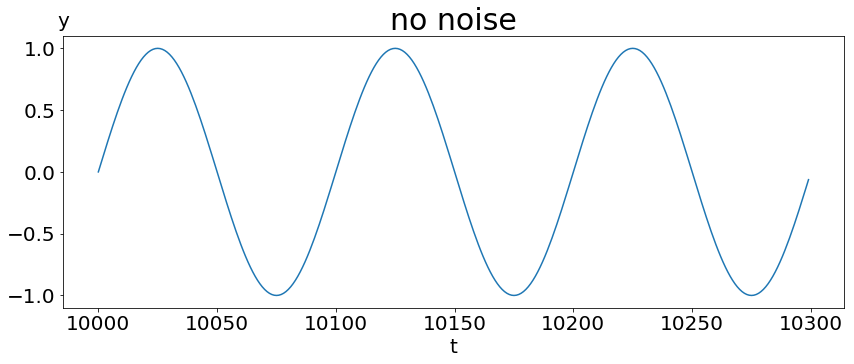

In [22]:
filename = "{}__wave_with_noise.png".format(ipynb_title)

#----------------------------------------
# create a wave
#----------------------------------------
t, wave = toy_func(tStart=tStart, tStop=tStart+wave_size, noiseAmpl=0)

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t, wave)

title = "no noise"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

In [23]:
#----------------------------------------
# create input data
#----------------------------------------
input_arr = np.empty(shape=(0, windowsize))
print(input_arr.shape)
for i in range( wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_arr = np.append(arr=input_arr,
                           values=wave[i:(i+windowsize)].reshape(1, -1),
                           axis=0)
print("input_arr.shape  : ", input_arr.shape)
input_arr = input_arr.reshape((-1, windowsize, 1))
print("input_arr.shape  : ", input_arr.shape)

(0, 100)
input_arr.shape  :  (200, 100)
input_arr.shape  :  (200, 100, 1)


## func

- 入力波形 : メソッド
- 削除したいチャネルがある層

In [24]:
from keras.models import load_model

In [25]:
modelpath = str(keras_model_h5_Path / model_filename)
model = load_model(filepath=modelpath)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 8)            88        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 1)            65        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [27]:
type(model)

keras.engine.sequential.Sequential

In [28]:
def removeIntermidiateChannels(input_array, model, layer_index=0, channel_index=[0]):
    """
    model : keras model
    layer_index : int
        層の順番
    channel_index=[]
        削除するチャネル
    reference:
      - https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    """
    from keras import backend as K

    # check input
    assert type(model) == keras.models.Sequential
    assert type(layer_index) == int
    assert type(channel_index) == list 

    # get first half layers output
    get_first_half = K.function(inputs=[model.input],
                                outputs=[model.layers[layer_index].output])
    first_half_output = get_first_half(inputs=[input_array])[0]

    # remove channels
    shape = first_half_output.shape[:2]
    for idx in channel_index:
        first_half_output[:,:,idx] = np.zeros(shape)

    # get second half layers output
    get_second_half = K.function(inputs=[model.layers[layer_index+1].input],
                                 outputs=[model.output])
    second_half_output = get_second_half(inputs=[first_half_output])[0]
    return second_half_output

In [29]:
removeIntermidiateChannels(model=model, layer_index=0, channel_index=[1], input_array=input_arr).shape

(200, 1)

In [30]:
removeIntermidiateChannels(model=model, layer_index=0, channel_index=[0, 1, 2, 3], input_array=input_arr).shape

(200, 1)

## Plot

In [31]:
channels_num = int(model.layers[0].output.shape[2])
channels_num

8

### Leave 1 channel

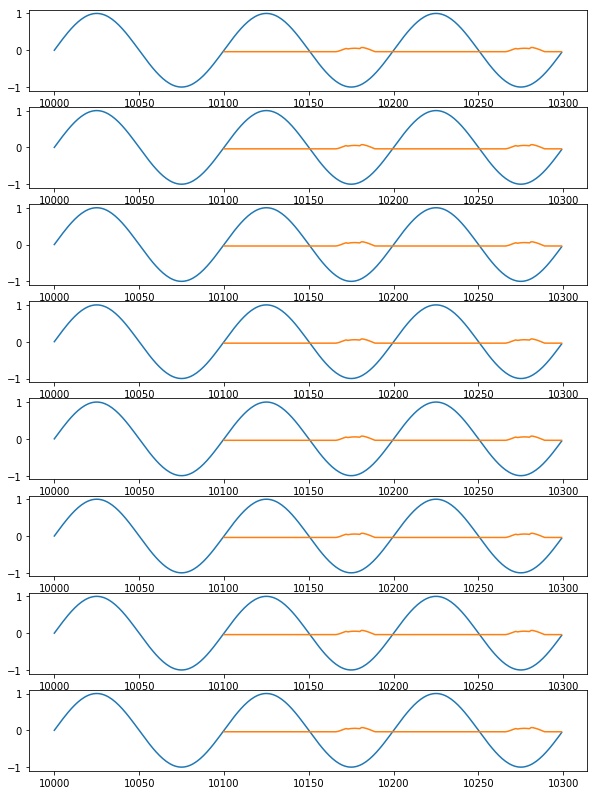

In [33]:
fig = plt.figure(figsize=(10, 14))
for ch in range(channels_num):
    ax = fig.add_subplot(channels_num,1,ch+1)
    ax.plot(t, wave)
    ch_list = [ ch for ch in range(channels_num) ]
    ch_list.remove(0)
    last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                   model=model,
                                                   layer_index=0,
                                                   channel_index=ch_list)
    ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())

### Remove 1 channel

ch0's, MSE : 0.00031070606561653077
ch1's, MSE : 0.09747437093532584
ch2's, MSE : 0.12111704299603447
ch3's, MSE : 0.14119928223950481
ch4's, MSE : 0.08063817614793332
ch5's, MSE : 0.0032203418183860155
ch6's, MSE : 0.002820284334158976
ch7's, MSE : 0.0006070120019275115


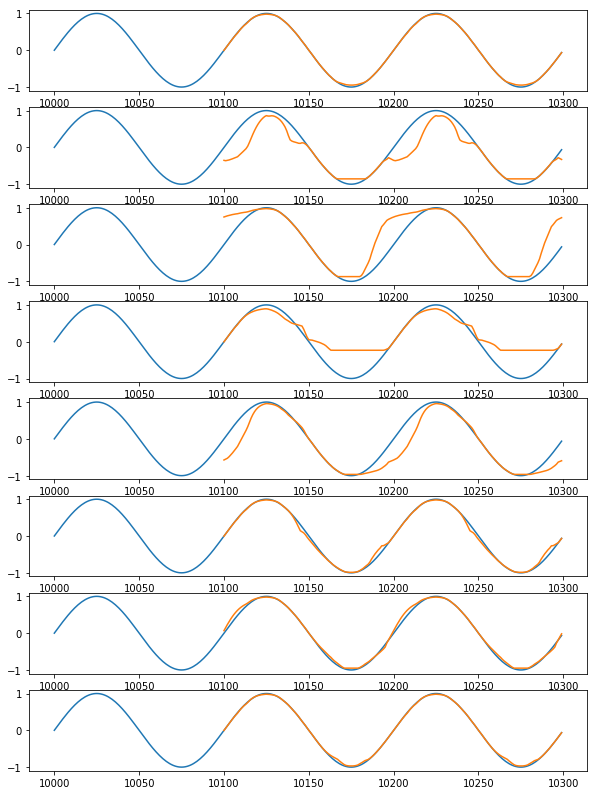

In [34]:
fig = plt.figure(figsize=(10, 14))
for ch in range(channels_num):
    ax = fig.add_subplot(channels_num,1,ch+1)
    ax.plot(t, wave)
    last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                   model=model,
                                                   layer_index=0,
                                                   channel_index=[ch])
    ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())
    mse = mean_squared_error(y_true=wave[windowsize:], y_pred=last_layer_output)
    print("ch{}'s, MSE : {}".format(ch, mse))

### Remove 2 channel

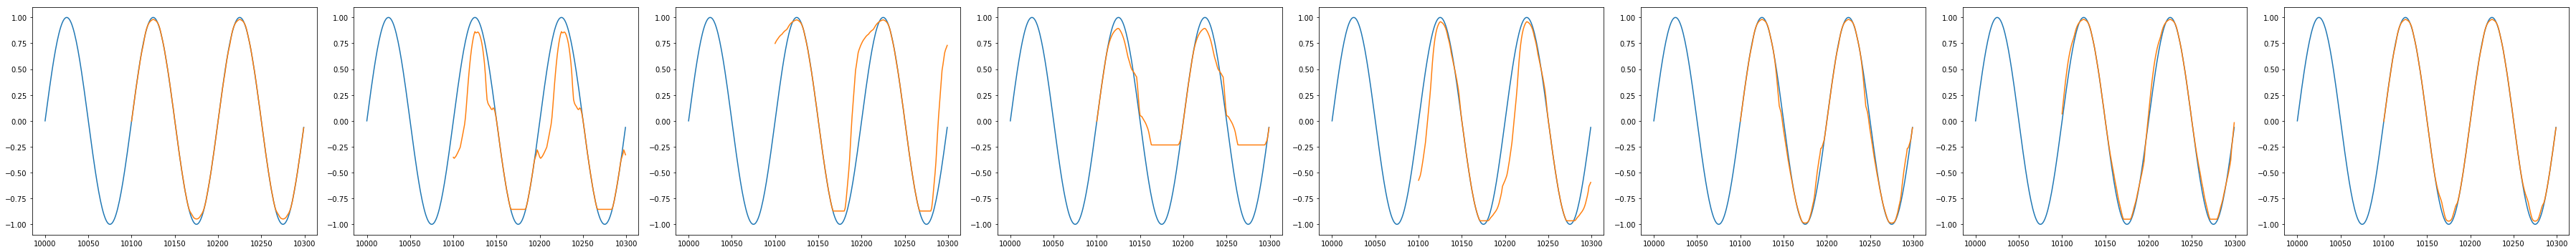

In [35]:
fig = plt.figure(figsize=(50, 5))
for ch in range(channels_num):
    ax = fig.add_subplot(1, channels_num, ch+1)
    ax.plot(t, wave)
    last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                   model=model,
                                                   layer_index=0,
                                                   channel_index=[ch])
    ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())
fig.tight_layout()

In [36]:
mse_remove2ch = np.zeros((channels_num, channels_num))
mse_remove2ch.shape

(8, 8)

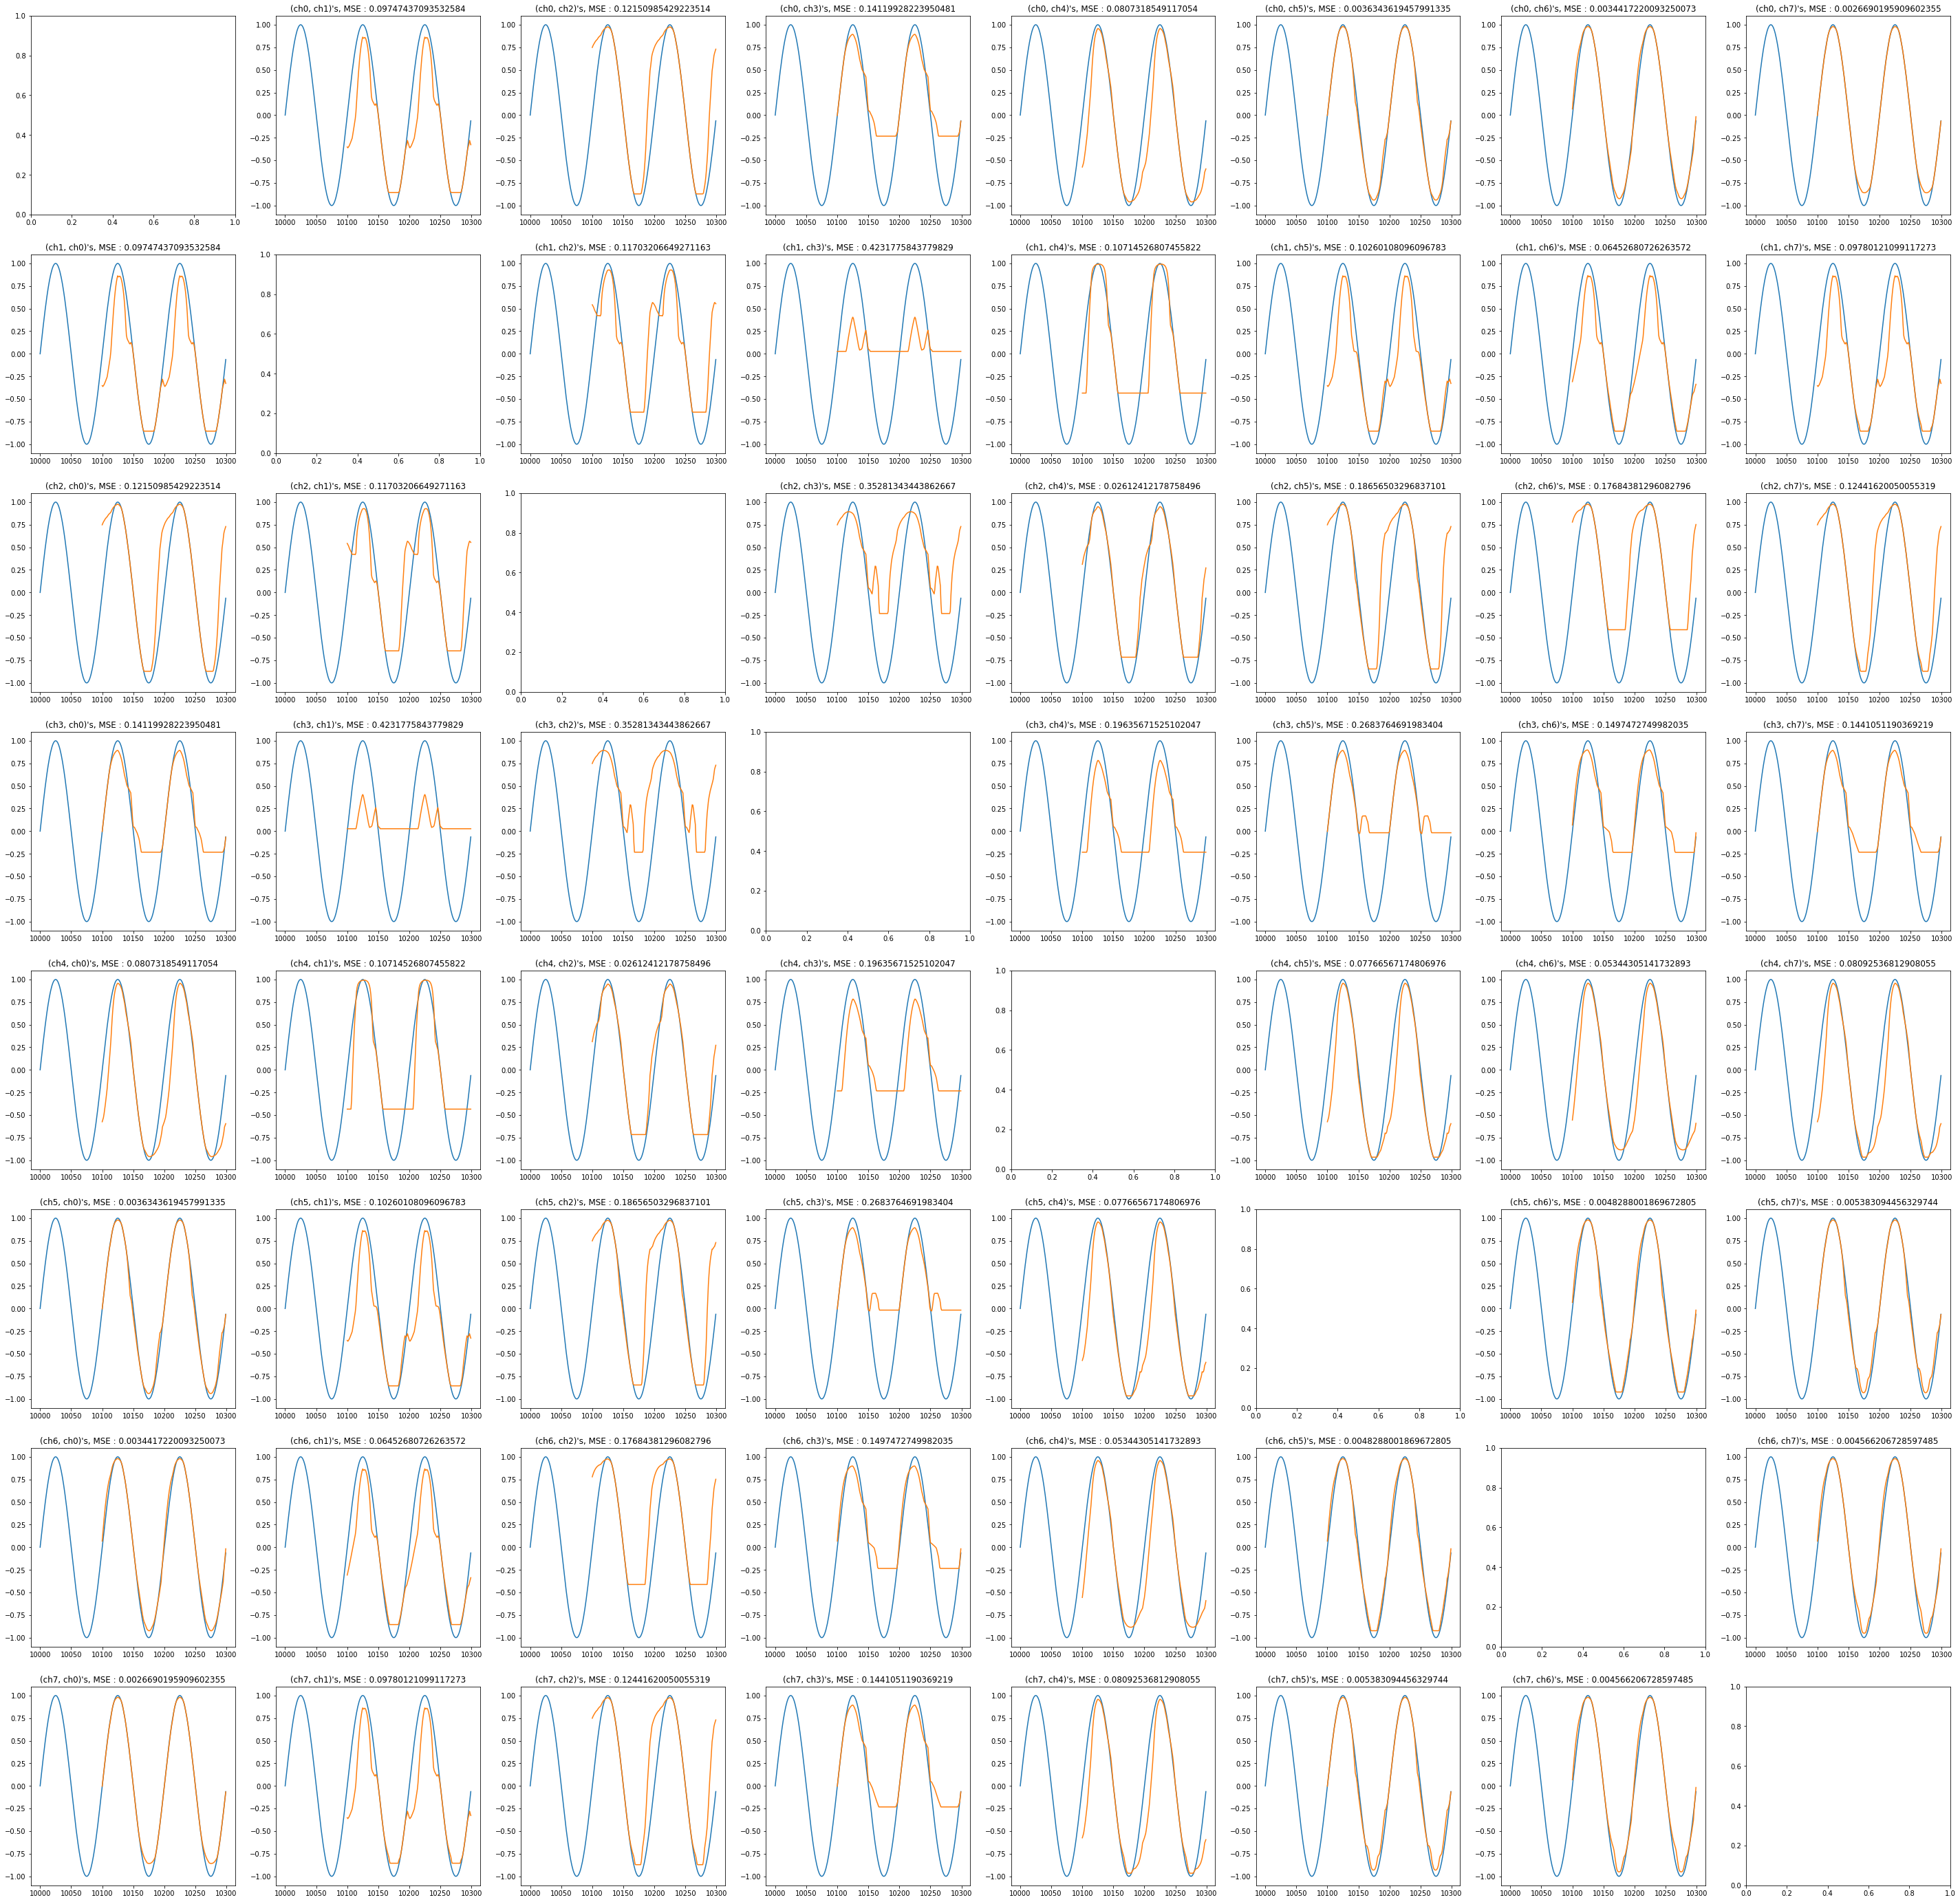

In [37]:
fig = plt.figure(figsize=(50, 50))
for ch1 in range(channels_num):
    for ch2 in range(channels_num):
        if ch1 == ch2:
            ax = fig.add_subplot(channels_num, channels_num, ch1*channels_num+ch2+1)
            #ax.plot(t, t)
        else:
            ax = fig.add_subplot(channels_num, channels_num, ch1*channels_num+ch2+1)
            ax.plot(t, wave)
            last_layer_output = removeIntermidiateChannels(input_array=input_arr,
                                                           model=model,
                                                           layer_index=0,
                                                           channel_index=[ch1, ch2])
            ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())
            mse = mean_squared_error(y_true=wave[windowsize:], y_pred=last_layer_output)
            ax.set_title(label="(ch{}, ch{})'s, MSE : {}".format(ch1, ch2, mse))
            mse_remove2ch[ch1, ch2] = mse
plt.show()

#### MSE colormap

max abs :  0.4231775843779829


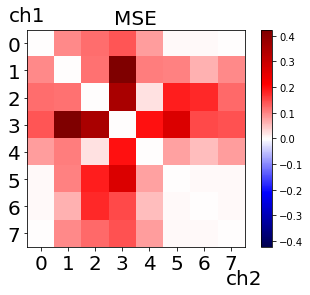

In [53]:

#--------------------
#  get max value for plot Color
#--------------------
max_abs = np.max(mse_remove2ch)
print("max abs : ", max_abs)



#------------------------------------------------------------
#  Plot
#------------------------------------------------------------
figsize = None
fontsize = 20

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
mappable = ax.imshow(mse_remove2ch,
                     cmap='seismic',  # <-- (min,max)=(blue, red)
                     vmin=-max_abs,
                     vmax=max_abs,
                     )
fig.colorbar(mappable,
             ax=ax,
             orientation='vertical',
             shrink=1.0,
             )
ax.set_title(label="MSE", fontsize=fontsize)
ax.set_xticks(ticks=np.arange(channels_num))
ax.set_yticks(ticks=np.arange(channels_num))
ax.set_xlabel(xlabel="ch2", fontsize=fontsize)
ax.xaxis.set_label_coords(x=1.0, y=-0.1)
ax.set_ylabel(ylabel="ch1", fontsize=fontsize, rotation=0)
ax.yaxis.set_label_coords(x=0, y=1.02)
ax.tick_params(labelsize=fontsize)
plt.show()

## End